# **Import libraries**

In [1]:
import os
import cv2
import numpy as np
import random
import time
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from keras.src.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Model
from keras.applications import MobileNet

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

## Load Data & Encoding labels ##

In [3]:
IMG_SIZE=224
data_path="/kaggle/input/product-classification/Product Classification/"

In [4]:
def Data_Preprocessing(root_folder,folder, IMG_SIZE):
    path_images = []
    labels = []

    # Iterate through each product folder
    for product_folder in os.listdir(root_folder):
        product_path = os.path.join(root_folder, product_folder)

        # List all image files in the training folder
        training_folder = os.path.join(product_path, folder)
        training_images = [os.path.join(training_folder, f) for f in os.listdir(training_folder)]
        # Add the paths and labels to the lists
        path_images.extend(training_images)
        labels.extend([int(product_folder)] * len(training_images))
    images=[]
    for path in path_images:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
    images = np.array(images, dtype='float32') / 255.0

    return images,labels

In [5]:
X_train, labels = Data_Preprocessing(data_path, 'Train',IMG_SIZE)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [6]:
onehotencoder = OneHotEncoder()
labels = np.array(labels).reshape(-1,1)
labels = onehotencoder.fit_transform(labels).toarray()
y_train=labels

## Augmentation For Train ##

In [7]:
training_datagen = ImageDataGenerator(
     horizontal_flip=True,
     vertical_flip=True,
     rotation_range=40,
     width_shift_range=0.2,
     height_shift_range=0.2,
     zoom_range=0.2,
     fill_mode="nearest",
)

training_datagen.fit(X_train)

# **MobileNet Model**

In [8]:
NUM_EPOCHS = 100
BATCH_SIZE = 64
Input_Shape=(IMG_SIZE,IMG_SIZE,3)

In [9]:
base_model = MobileNet(input_shape=Input_Shape,  # Shape of our images
                   include_top=False,  # Leave out the last fully connected layer
                   weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

# Flatten the output layer to 1 dimension
x = Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

# Add a final Softmax layer with 20 node for classification output
x = Dense(20, activation='Softmax')(x)
model = Model(base_model.input, x)

17225924/17225924 [==============================] - 0s 0us/step


# Compile Model

In [10]:
# opt = keras.optimizers.Adam(learning_rate=1e-5)
# model.compile(optimizer=opt,
#               loss=tf.losses.categorical_crossentropy,
#               metrics=['accuracy'])

model.compile(optimizer='adam',
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [11]:
start_train = time.time()

# Fit Model

In [12]:
history=model.fit(training_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),epochs=NUM_EPOCHS)

Epoch 1/100
3/3 [==============================] - 9s 116ms/step - loss: 17.9434 - accuracy: 0.0643
Epoch 2/100
3/3 [==============================] - 1s 377ms/step - loss: 21.0274 - accuracy: 0.1929
Epoch 3/100
3/3 [==============================] - 2s 404ms/step - loss: 12.3421 - accuracy: 0.3286
Epoch 4/100
3/3 [==============================] - 2s 708ms/step - loss: 7.4458 - accuracy: 0.4857
Epoch 5/100
3/3 [==============================] - 2s 427ms/step - loss: 4.1332 - accuracy: 0.6214
Epoch 6/100
3/3 [==============================] - 2s 692ms/step - loss: 4.0819 - accuracy: 0.6429
Epoch 7/100
3/3 [==============================] - 2s 402ms/step - loss: 2.8981 - accuracy: 0.7214
Epoch 8/100
3/3 [==============================] - 2s 406ms/step - loss: 1.9178 - accuracy: 0.7714
Epoch 9/100
3/3 [==============================] - 2s 402ms/step - loss: 2.5763 - accuracy: 0.7143
Epoch 10/100
3/3 [==============================] - 2s 394ms/step - loss: 1.2982 - accuracy: 0.8214
Epoch 

In [13]:
end_train = time.time()

In [14]:
model.save('MobileNet_Model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Plot the training accuracy and loss at each epoch # 

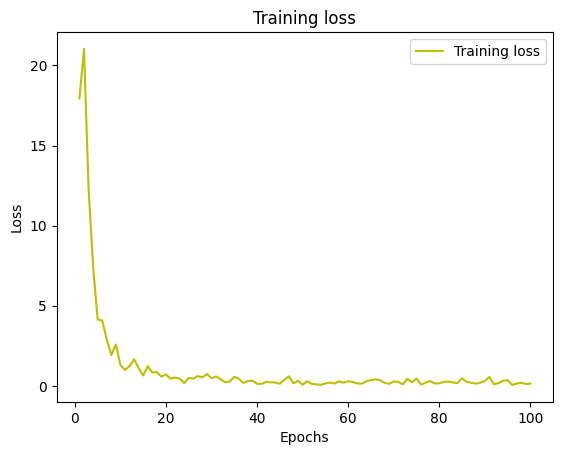

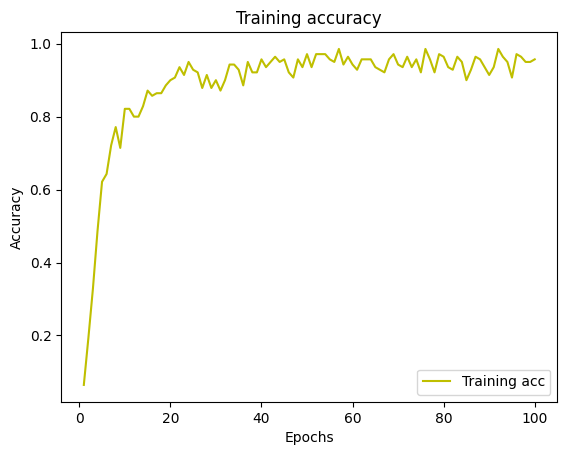

In [15]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Time of Training**

In [16]:
Training_time = end_train - start_train

In [17]:
print('Training Time MobileNet ',Training_time)

Training Time MobileNet  160.1045093536377
